# 제 3 고지. 고차 미분 계산

- 고차 미분이란 어떤 함수를 2번 이상 미분한 것
- 구체적으로 1차 미분, 2차 미분, 3차 미분... 식으로 미분을 반복합니다. 
- 파이토치와 텐서플로 등 현대적인 딥러닝 프레임워크에서는 고차 미분을 자동으로 계산할 수 있습니다. 
- 즉, 역전파에 대한 역전파를 할 수 있습니다. 
- 이번 고지에서는 고차 미분을 계산할 수 있도록 DeZero를 확장하는 일을 합니다. 
- 그 결과 DeZero이 활용폭이 한층 넓어집니다. 


# 25. 계산 그래프 시각화(1)

- 복잡한 식을 계산 그래프로 시각화 해 보겠습니다. 
- 계산 그래프를 시각화 하면 문제가 발생했을 때 원인이 되는 부분을 파악하기 쉬워집니다. 또한 더 나은 계산 방법을 발견할 수도 있고, 신경망의 구조를 3자에게 시각적으로 전달하는 용도로도 활용할 수 있습니다. 

## 25.1 Graphviz 설치하기

- \$ sudo apt install graphviz
- \$ dot -V (dot - graphviz version 2.43.0 (0))
- \$ dot sample.dot -T png -o sample.png

In [ ]:
digraph g{
x
y
}

## 25.2 DOT 언어로 그래프 작성하기

![title](image/그림25-1.png)

## 25.3 노드에 속성 지정하기

In [ ]:
digraph g{
1 [label="x", color=orange, style=filled]
2 [label="y", color=orange, style=filled]    
}

![title](image/그림25-2.png)

In [ ]:
digraph g{
1 [label="x", color=orange, style=filled]
2 [label="y", color=orange, style=filled]    
1 [label="Exp", color=lightblue, style=filled, shape=box]    
}

![title](image/그림25-3.png)

## 25.4 노드 연결하기

In [ ]:
digraph g{
1 [label="x", color=orange, style=filled]
2 [label="y", color=orange, style=filled]    
1 [label="Exp", color=lightblue, style=filled, shape=box]    
1 -> 3
3 -> 2    
}

![title](image/그림25-4.png)

# 26. 계산 그래프 시각화(2)

- DOT 언어를 바탕으로 DeZero 계산 그래프를 DOT 언어로 변환합니다. 

## 26.1 시각화 코드 예

![title](image/그림26-1.png)

In [ ]:
import numpy as np
from dezero import Variable
from dezero.utils import plot_dot_graph

x0 = Variable(np.array(1.0))
x1 = Variable(np.array(1.0))
y = x0 + x1  # 어떤 계산

# 변수 이름 지정
x0.name = 'x0'
x1.name = 'y1'
y.name = 'y'

txt = get_dot_graph(y, verbose = False)
print(txt)

# dot 파일로 저장
with open('sample.dot', 'w') as o:
    o.write(txt)

## 26.2 계산 그래프에서 DOT 언어로 변환하기

![title](image/그림26-2.png)

In [14]:
def _dot_var(v, verbose=False):
    dot_var = '{} [label="{}", color=orange, style=filled]\n'

    name = '' if v.name is None else v.name
    if verbose and v.data is not None:
        if v.name is not None:
            name += ': '
        name += str(v.shape) + ' ' + str(v.dtype)

    return dot_var.format(id(v), name)

In [15]:
# 사용 예

x = Variable(np.random.randn(2, 3))
x.name = 'x'
print(_dot_var(x))
print(_dot_var(x, verbose=True))

139861591168592 [label="x", color=orange, style=filled]

139861591168592 [label="x: (2, 3) float64", color=orange, style=filled]



In [16]:
def _dot_func(f):
    # for function
    dot_func = '{} [label="{}", color=lightblue, style=filled, shape=box]\n'
    ret = dot_func.format(id(f), f.__class__.__name__)

    # for edge
    dot_edge = '{} -> {}\n'
    for x in f.inputs:
        ret += dot_edge.format(id(x), id(f))
    for y in f.outputs:  # y is weakref
        ret += dot_edge.format(id(f), id(y()))
    return ret

In [17]:
# 사용 예

x0 = Variable(np.array(1.0))
x1 = Variable(np.array(1.0))
y = x0 + x1
txt = _dot_func(y.creator)
print(txt)

139861590099024 [label="Add", color=lightblue, style=filled, shape=box]
139861590098960 -> 139861590099024
139861590098896 -> 139861590099024
139861590099024 -> 139861590099152



- 계산 그래프를 DOT 언어로 변환할 때는 '어떤 노드가 존재하는가'와 '어떤 노드끼리 연결되는가'가 문제임
- 즉, 노드의 추적 순서는 문제가 되지 않기 때문에 generation을 사용하여 순서대로 꺼내는 구조는 사용하지 않아도 됨

In [18]:
def get_dot_graph(output, verbose=True):
    txt = ''
    funcs = []
    seen_set = set()

    def add_func(f):
        if f not in seen_set:
            funcs.append(f)
            # funcs.sort(key=lambda x: x.generation)  # 노드를 추적하는 순서가 문제가 되지 않으므로 주석 처리
            seen_set.add(f)

    # Variable 클래스의 backward 메서드에서는 미분값을 전파했지만, 여기에서는 미분 대신 DOT 언어로 기술한 문자열을 txt에 추가함
    add_func(output.creator)
    txt += _dot_var(output, verbose) # Variable 클래스의 backward 메서드에서 달라진 부분

    while funcs:
        func = funcs.pop()
        txt += _dot_func(func)  # Variable 클래스의 backward 메서드에서 달라진 부분
        for x in func.inputs:
            txt += _dot_var(x, verbose) # Variable 클래스의 backward 메서드에서 달라진 부분

            if x.creator is not None:
                add_func(x.creator)

    return 'digraph g {\n' + txt + '}' # Variable 클래스의 backward 메서드에서 달라진 부분

## 26.3 이미지 변환까지 한 번에

- get_dot_graph 함수는 계산 그래프를 DOT 언어로 변환합니다. 
- 그런데 DOT 언어를 이미지로 변환하려면 dot 명령을 수동으로 실행해야 하므로 매번 하긴 번거롭습니다. 
- 그래서 dot 명령 실행까지 한 번에 해주는 함수를 제공하려 합니다. 

In [19]:
import os
import subprocess

def plot_dot_graph(output, verbose=True, to_file='graph.png'):
    dot_graph = get_dot_graph(output, verbose)

    # dot 데이터를 파일에 저장
    tmp_dir = os.path.join(os.path.expanduser('~'), '.dezero')  # 사용자의 홈 디렉토리를 뜻하는 '~'를 절대 경로로 풀어줌
    if not os.path.exists(tmp_dir):
        os.mkdir(tmp_dir)
    graph_path = os.path.join(tmp_dir, 'tmp_graph.dot')

    with open(graph_path, 'w') as f:
        f.write(dot_graph)

    # dot 명령 호출
    extension = os.path.splitext(to_file)[1][1:]  # to_file에 저장할 이미지 파일 이름을 지정함. Extension(e.g. png, pdf)
    cmd = 'dot {} -T {} -o {}'.format(graph_path, extension, to_file)
    subprocess.run(cmd, shell=True)  # 파이썬 외부 프로그램을 호출하기 위해 사용
    
    # Return the image as a Jupyter Image object, to be displayed in-line. 주피터 노트북에서 실행할 경우 이미지 출력 기능
    try:
        from IPython import display
        return display.Image(filename=to_file)
    except:
        pass

## 26.4 동작 확인

- 24단계에서 구현한 Goldstein_Price 함수를 시각화 해 보겠습니다. 
- 자세히 보면 입력 변수 x와 y에서 시작하여 최종적으로 변수 z가 출력되고 있음을 알 수 있습니다. 
- 참고로 Goldstein_Price 함수를 DeZero에서 구현할 때 수식을 거의 그대로 코드에 옮길 수 있었는데, 그 뒤편에는 아래 그림처럼 복잡하게 얽힌 계산 그래프가 만들어져 있던 것입니다!
- 이상으로 계산 그래프를 시각화해봤습니다. 여기에서 구현한 시각화 함수는 앞으로도 필요할 때 마다 계속 이용할 것입니다. 

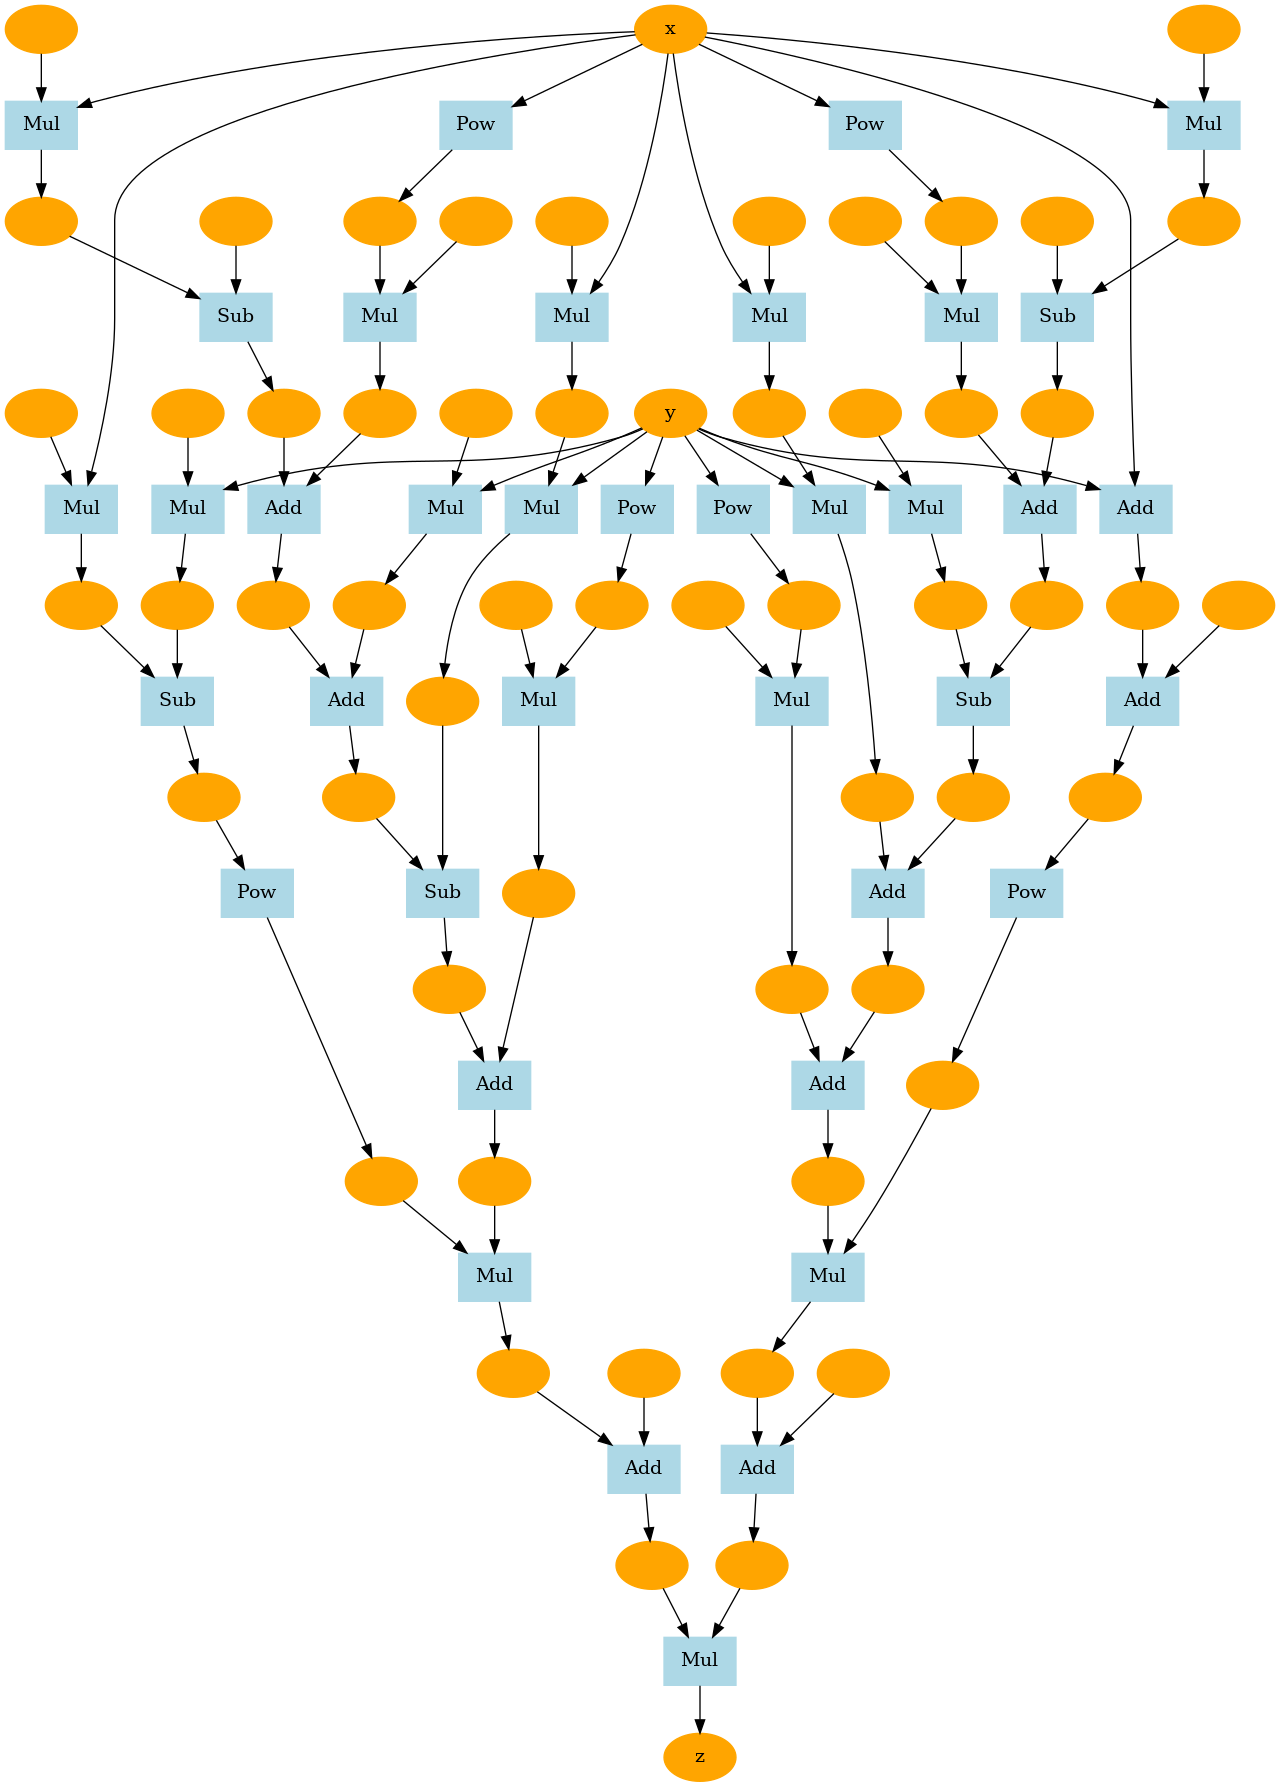

In [12]:
'''
Need the dot binary from the graphviz package (www.graphviz.org).
'''
if '__file__' in globals():
    import os, sys
    sys.path.append(os.path.join(os.path.dirname(__file__), '..'))
import numpy as np
from dezero import Variable
from dezero.utils import plot_dot_graph


def goldstein(x, y):
    z = (1 + (x + y + 1)**2 * (19 - 14*x + 3*x**2 - 14*y + 6*x*y + 3*y**2)) * \
        (30 + (2*x - 3*y)**2 * (18 - 32*x + 12*x**2 + 48*y - 36*x*y + 27*y**2))
    return z


x = Variable(np.array(1.0))
y = Variable(np.array(1.0))
z = goldstein(x, y)
z.backward()
# 사용 예

x = Variable(np.random.randn(2, 3))
x.name = 'x'
print(_dot_var(x))
print(_dot_var(x, verbose=True))
x.name = 'x'
y.name = 'y'
z.name = 'z'
plot_dot_graph(z, verbose=False, to_file='goldstein.png')

# 27. 테일러 급수 미분

- 지금부터는 DeZero를 사용하여 구체적인 문제를 몇 개 풀어보겠습니다. 
- 이번 단계의 목표는 sin 함수의 미분입니다. 
- 아시듯이 sin의 미분은 해석적으로 풀립니다. https://tipe.tistory.com/entry/%EC%82%BC%EA%B0%81%ED%95%A8%EC%88%98%EC%9D%98-%EB%AF%B8%EB%B6%84-%EC%A6%9D%EB%AA%85
- 그러니 우선은 정공법을 써서 sin 함수를 DeZero로 구현하고, 이어서 그 미분을 테일러 급수를 이용해 계산해 보겠습니다 

## 27.1 sin 함수 구현

- sin의 미분은 해석적으로 풀 수 있습니다. $y = sin(x)$ 일 때 그 미분은 $dy/dx=cos(x)$입니다. 
- 따라서 Sin 클래스와 sin 함수는 아래처럼 구현할 수 있습니다. 

In [20]:
import numpy as np
from dezero import Function


class Sin(Function):
    def forward(self, x):
        y = np.sin(x)
        return y

    def backward(self, gy):
        x = self.inputs[0].data
        gx = gy * np.cos(x)
        return gx

    
def sin(x):
    return Sin()(x)

In [22]:
from dezero import Variable

x = Variable(np.array(np.pi / 4))
y = sin(x)
y.backward()

print(y.data)
print(x.grad)

0.7071067811865475
0.7071067811865476


## 27.2 테일러 급수 이론

- 이제부터 sin 함수의 미분을 테일러 급수(Taylor Series)를 이용해서 계산해보려고 합니다. 
- 테일러 급수란 어떤 함수를 다항식으로 근사하는 방법으로, 수식으로는 다음과 같습니다. 
    
![title](image/식27.1.png)

- 2차 이분은 미분한 값을 한 번 더 미분한 것입니다. 
    - 물리 세계에서 예를 찾아보면 위치의 미분(변화)은 속도이며, 
    - 속도의 미분(변화)은 가속도입니다. 
    - 이 때 속도가 1차 미분이고 가속도가 2차 미분에 해당합니다. 
- 1차 미분, 2차 미분, 3차 미분... 식으로 항이 무한히 계속되지만, 어느 시점에서 중단하면 $f(x)$의 값을 근사할 수 있습니다. 
- 물론 항이 많아질수록 근사의 정확도가 높아집니다. 

- a=0 일 때의 테일러 급수를 매클로린 전개(Maclaurin's series)라고도 합니다. 
- 위 식에 a=0을 대입하면 다음과 같이 됩니다. 
   
![title](image/식27.2.png)

- a=0으로 한정함으로써 더 간단한 수식이 되었습니다. 이제 $f(x)=sin(x)$를 위 식에 적용시켜 보겠습니다. 
- 그러면 sin, cos이 반복되는데, sin(0)=0, cos(0)=1 이므로 다음 식을 이끌어 낼 수 있습니다. 

![title](image/식27.3.png)

- 위에서 보듯 sin 함수는 x의 거듭제곱으로 이루어진 항들이 무한히 계속되는 형태로 표현됩니다. 
- 여기서 중요한 점은 i가 커질수록 근사 정밀도가 좋아진다는 것입니다. 
- 또한 i가 커질수록 위 식의 절대값은 작아지므로 이 값을 참조하여 i의 값(반복 횟수)을 적절히 결정할 수 있습니다. 

## 27.3 테일러 급수 구현

- 위 식에 따라 sin 함수를 구현해 보겠습니다. 
- 계승 계산은 파이썬dml math 모듈에 있는 math.factorial 함수를 사용하겠습니다. 

In [5]:
import math

def my_sin(x, threshold=0.0001):
    y = 0
    for i in range(100000):   # for문 안에 i번째에 추가할 항목을 t로 하여 위 식을 구현했습니다. 
        c = (-1) ** i / math.factorial(2 * i + 1)
        t = c * x ** (2 * i + 1)
        y = y + t
        if abs(t.data) < threshold:    # 임계값을 지정해서 t의 절대값이 임계값보다 낮아지만 for문을 빠져나오게 했습니다. 
            break                      # threshold로 근사치의 정밀도를 조정하는 것입니다. (treshold가 작을 수록 정밀도가 높아짐)
    return y

In [6]:
x = Variable(np.array(np.pi / 4))
y = my_sin(x)  # , threshold=1e-150)
y.backward()

print(y.data)
print(x.grad)

0.7071064695751781
0.7071032148228457


- 앞의 sin 함수와 거의 같은 결과를 얻었습니다. 오차는 무시할 정도로 작습니다. 
- 더구나 treshold 값을 줄이면 이마저도 더 줄일 수 있습니다. 

## 27.4 계산 그래프 시각화

- 앞 절의 코드를 실행하면 아래와 같은 계산 그래프가 나옵니다. 
- 우선 treshold=0.0001 일때, my_sin 함수의 계산 그래프는 아래와 같습니다. 

--- original sin ---
0.7071067811865475
0.7071067811865476
--- approximate sin ---
0.7071064695751781
0.7071032148228457


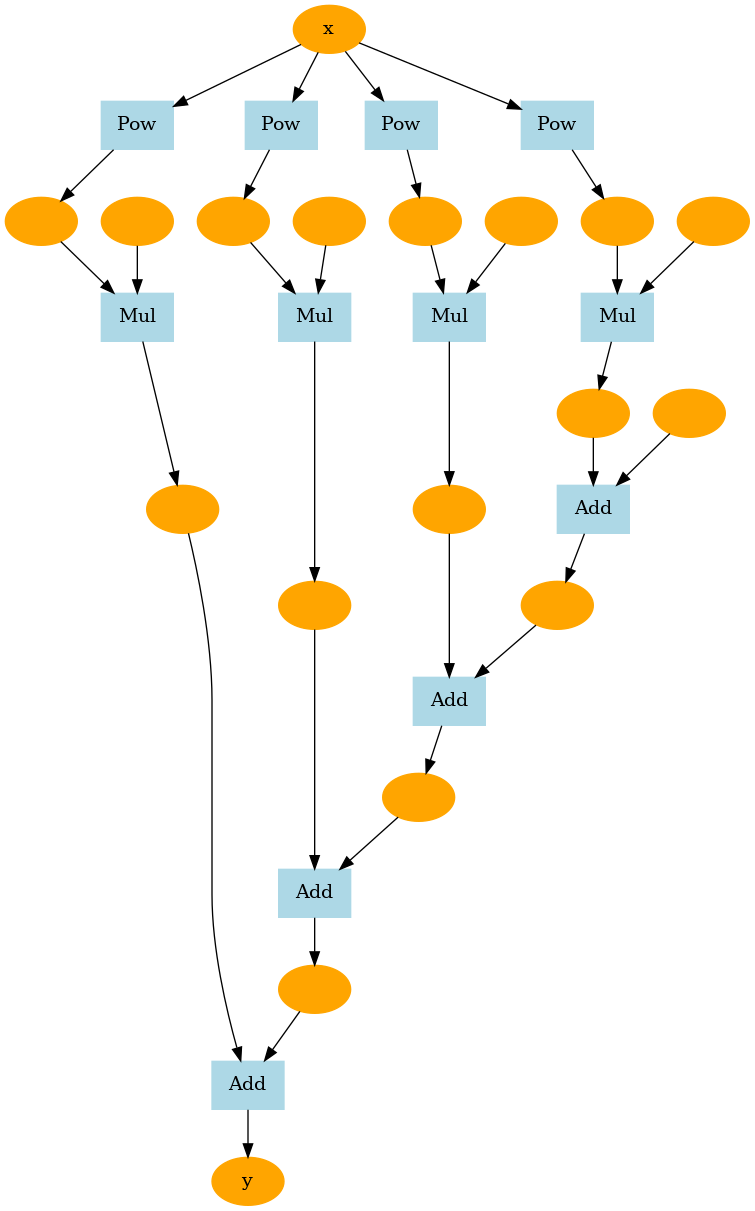

In [4]:
if '__file__' in globals():
    import os, sys
    sys.path.append(os.path.join(os.path.dirname(__file__), '..'))
import numpy as np
import math
from dezero import Variable, Function
from dezero.utils import plot_dot_graph


class Sin(Function):
    def forward(self, x):
        y = np.sin(x)
        return y

    def backward(self, gy):
        x = self.inputs[0].data
        gx = gy * np.cos(x)
        return gx


def sin(x):
    return Sin()(x)


x = Variable(np.array(np.pi / 4))
y = sin(x)
y.backward()
print('--- original sin ---')
print(y.data)
print(x.grad)


def my_sin(x, threshold=0.0001):
    y = 0
    for i in range(100000):
        c = (-1) ** i / math.factorial(2 * i + 1)
        t = c * x ** (2 * i + 1)
        y = y + t
        if abs(t.data) < threshold:
            break
    return y


x = Variable(np.array(np.pi / 4))
y = my_sin(x)  # , threshold=1e-150)
y.backward()
print('--- approximate sin ---')
print(y.data)
print(x.grad)

x.name = 'x'
y.name = 'y'
plot_dot_graph(y, verbose=False, to_file='my_sin.png')


- 위 그림은 sin 함수를 근사하기 위해 만들어진 계산 그래프입니다. 
- 여기에서 흥미로운 점은 threshold 값으로 '계산 그래프의 복잡성'을 제어한다는 것입니다. 
- 시험삼아 threshold=1e-150으로 설정하여 계산그래프를 시각화 하면 아래와 같습니다. 

![title](image/그림27-2.png)

- threshold 값을 줄이자 for문의 반복 횟수가 늘어나서 위와 같은 '깊은 계산 그래프'가 만들어졌습니다. 
- 방금 우리는 이렇게 큰 계산 그래프를 단순히 파이썬의 for 문과 if 문을 사용하여 만들었습니다.
- (다른 특별한 구조가 아닌) 파이썬의 제어 구문만으로 지극히 평범한 코드를 작성한 것입니다. 
- 여기서 우리는 DeZero가 제공하는 Define_by_Run의 '사용 편의성'이 이미 상당한 수준에 도달했음을 알 수 있습니다. 

# 28. 함수 최적화

- DeZero는 이제 미분을 자동으로 계산할 줄 압니다. 
- 미분은 다양한 분야에서 다양한 용도로 활용되며, 그중 가장 중요한 용도로 함수 최적화를 들 수 있습니다. 
- 이번 단계에서는 구체적인 함수를 대상으로 최적화를 해보겠습니다. 
    - 최적화란 어떤 함수가 주어졌을 때 그 최솟값(또는 최댓값)을 반환하는 '입력(함수의 인수)'을 찾는 일입니다. 
    - 신경망 학습의 목표도 손실 함수의 출력을 최소화하는 매개변수를 찾는 것이니 최적화 문제에 속합니다. 
    - 따라서 이번 단계에서 수행하는 내용은 그대로 신경망 학습에도 적용할 수 있습니다. 

## 28.1 로젠브록 함수

- 이번 단계에서는 로젠브록 함수를 다룹니다. 

![title](image/식28.1.png)

- 아래 그림을 보면 포물선 모양으로 깊게 뻗은 골짜기가 보입니다. 
- 참고로 '산'에 등고선을 그리면 그 모양이 바나나를 닮았다고 ㅎ여 로젠브록 함수를 바나나 함수라고도 합니다. 

![title](image/그림28-1.png)

- 이번 단계의 목표는 로젠브록 함수의 출력이 최소가 되는 $x_0$와 $x_1$을 찾는 것입니다. 
- 답부터 말하면 로젠브록 함수의 최솟값은 $(x_0, x_1)=(1,1)$ 입니다. 
- 이번 단계에서는 DeZero를 사용하여 이 최솟값을 실제로 찾아낼 수 있는지 확인합니다. 
- 로젠브록 함수의 올바른 정의는 $a, b$가 정수일 때 $f(x_0,x_1)=b(x_1-x_0^2)^2 + (a-x_0)^2$입니다. 
- 그래서 위의 식과 그림은 $a=1, b=100$일 때의 로젠브록 함수에 해당합니다. 
- 로젠브록 함수는 최적화 문제의 벤치마크 함수로 자주 사용되며, 지금 예처럼 $a=1, b=100$으로 설정하여 벤치마크 하는 것이 일반적입니다. 

## 28.2 미분 계산하기

- 가장 먼저 로젠브록 함수의 $(x_0, x_1)=(0.0, 2.0)$에서의 미분($dy/dx_0와 dy/dx_1$)을 계산해 봅시다. 

In [7]:
import numpy as np
from dezero import Variable

def rosenbrock(x0, x1):
    y = 100 * (x1 - x0 ** 2) ** 2 + (x0 - 1) ** 2
    return y

In [8]:
x0 = Variable(np.array(0.0))
x1 = Variable(np.array(2.0))

y = rosenbrock(x0, x1)
y.backward()              # 자동 미분 계산
print(x0.grad, x1.grad)

-2.0 400.0


- 이때 두 미분값을 모은 값, 즉 (-2.0, 400.0) 벡터를 기울기 혹은 기울기 벡터라고 합니다. 
- 기울기는 각 지점에서 함수의 출력을 가장 크게 하는 방향을 가리킵니다. 
- 지금 예에서의 $(x_0, x_1)=(0.0, 2.0)$ 지점에서 y값을 가장 크게 늘려주는 방향이 (-2.0, 400.0)이라는 의미입니다. 
- 반대로 기울기에 마이너스를 곱한 (2.0, -400.0) 방향은 y값을 가장 작게 줄여주는 방향을 뜻합니다. 

## 28.3 경사하강법 구현

- 복잡한 형상의 함수라면 기울기가 가리키는 방향에 반드시 최댓값이 존재한다고는 볼 수 없습니다. (마찬가지로 반대 방향이 최솟값이 존재한다고 볼 수도 없습니다.)
- 그러나 국소적으로 보면 기울기는 함수의 출력을 가장 크게 하는 방향을 나타냅니다. 
- 그래서 기울기 방향으로 일정 거리만큼 이동하여 다시 기울기를 구하는 작업을 반복하면 점차 원하는 지점(최댓값 혹은 최솟값)에 접근하리라 기대할 수 있습니다. 
- 이것이 경사하강법입니다. 
- 알맞는 지점에서 시작하면(좋은 초깃값을 주면) 경사하강법은 우리를 목적지까지 효율적으로 안내해 줍니다. 
- 그러면 경사하강법을 적용해서, 로젠브록 함수의 최솟값을 찾아봅니다. 
- 따라서 기울기 방향에 마이더스를 곱한 방향으로 이동합니다. 

In [9]:
x0 = Variable(np.array(0.0))
x1 = Variable(np.array(2.0))
lr = 0.001
iters = 1000

for i in range(iters):
    print(x0, x1)

    y = rosenbrock(x0, x1)

    # x0, x1 Variable 인스턴스를 반복 사용하여 미분값을 구하므로, x0.grad, x1.grad에는 미분값이 계속 누적되기 때문에 새롭게 미분할 때는 
    x0.cleargrad()  # 지금까지 누적된 값을 초기화해야 합니다. 그래서 역전파하기 전에 각 변수의 
    x1.cleargrad()  # cleargrad 메서드를 호출하여 미분값을 초기화한 것입니다. 
    y.backward()

    x0.data -= lr * x0.grad
    x1.data -= lr * x1.grad

variable(0.0) variable(2.0)
variable(0.002) variable(1.6)
variable(0.0052759968) variable(1.2800008)
variable(0.009966698110960038) variable(1.0240062072284468)
variable(0.01602875299014943) variable(0.8192248327970044)
variable(0.02324750923068761) variable(0.6554312504220874)
variable(0.031290846214210376) variable(0.5244530896747561)
variable(0.039780241951514035) variable(0.41975829515116514)
variable(0.04835473570612382) variable(0.3361231296508763)
variable(0.05671405943493354) variable(0.26936613981374286)
variable(0.06463840226323121) variable(0.2161362087585121)
variable(0.07198937826156711) variable(0.17374459161623834)
variable(0.07869927242171229) variable(0.14003216740948807)
variable(0.08475507379959696) variable(0.11326444902353183)
variable(0.0901819257435144) variable(0.0920482437257805)
variable(0.09502862514911821) variable(0.07526515092678615)
variable(0.09935624532071949) variable(0.062018208660975245)
variable(0.10322996680416148) variable(0.05158889962562639)
var

- 이와 같이 반복 횟수를 iters로 설정합니다. (iterations 약자)
- 기울기에 곱하는 값을 미리 설정해 두고 (lr = 0.001, learning rate 약자) 있습니다. 
- 코드를 실행해 보면 $(x_0, x_1)$ 값이 출발점 (0.0, 2.0)에서 시작하여 위치가 계속 갱신되는 모습을 볼 수 있습니다. 
- 아래 그림은 이 결과를 플롯한 모습입니다. 

![title](image/그림28-2.png)

- 위 그림을 보면 목적지인 별의 위치에 서서히 접근하고 있음을 알 수 있습니다. 
- 다만 중간에 멈춘 것 같습니다. 그래서 반복 횟수를 iters = 10000으로 늘려 다시 실행해 봤습니다. 그 결과가 아래 그림입니다. 

![title](image/그림28-3.png)

- 위 그림에서는 목적지에 더 가까워졌습니다. 이 때 $(x_0, x_1)$ 값은 (0.99449622, 0.98900063) 입니다. 
- iters = 50000 으로 설정해 실행하면 실제로 (1.0, 1.0) 위치에 간신히 도착합니다. 

- 이번 단계에서는 DeZero를 사용하여 경사하강법을 구현했고, 이를 이용해 로젠브룩 함수의 최솟값 위치를 찾을 수 있었습니다. 
- 그러나 50,000번이나 반복한다는 것은 너무 과해 보입니다. 
- 사실 경사하강법은 로젠브록 함수 같이 골짜기가 길게 뻗은 함수에는 잘 대응하지 못합니다. 
- 그래서 다음 단계에서는 또 다른 최적화 기업을 소개하고 구현할 예정입니다. 

In [ ]:
# step 28 전체 코드

if '__file__' in globals():
    import os, sys
    sys.path.append(os.path.join(os.path.dirname(__file__), '..'))
import numpy as np
from dezero import Variable
# import dezero's simple_core explicitly
import dezero
if not dezero.is_simple_core:
    from dezero.core_simple import Variable
    from dezero.core_simple import setup_variable
    setup_variable()


def rosenbrock(x0, x1):
    y = 100 * (x1 - x0 ** 2) ** 2 + (x0 - 1) ** 2
    return y


x0 = Variable(np.array(0.0))
x1 = Variable(np.array(2.0))
lr = 0.001
iters = 1000

for i in range(iters):
    print(x0, x1)

    y = rosenbrock(x0, x1)

    x0.cleargrad()
    x1.cleargrad()
    y.backward()

    x0.data -= lr * x0.grad
    x1.data -= lr * x1.grad

# 29. 뉴턴 방법으로 푸는 최적화(수동 계산)

- 앞의 예에서 경사하강법은 일반적으로 수렴이 느리다는 단점이 있습니다. (앞에서 5만번 가까이 반복한 사례)
- 경사하강법을 대체할 수 있는 수렴이 더 빠른 방법으로 유명한 것에는 뉴턴 방법(Newton's method)이 있습니다. 
- 더 적은 단계로 최적의 결과를 얻을 가능성이 높아집니다. 
- 뉴턴 방법으로 이전 단계의 문제를 풀면 아래의 오른쪽과 같은 결과를 얻을 수 있습니다. 

![title](image/그림29-1.png)

- 위 그림을 보면 경사하강법이 '계곡'에서 고전하면서 서서히 목표값에 접근해가는 반면 뉴턴 방법은 계곡을 뛰어넘어 단번에 목적지에 도착합니다. 
- 갱신 횟수는 불과 6회입니다! 경사하강법에서 5만번 가까이 필요했던 갱신이 불과 6회에 끝나다니, 극적인 차이가 아닐 수 없습니다. 
- 로젠브록 함수에서는 경사하강법과 뉴턴 방법의 갱신 횟수 차이가 아주 크게 나왔습니다. 
- 물론 이 횟수는 초깃값이나 학습률 등을 어떻게 설정하느냐에 크게 좌우되며, 이렇게까지 큰 차이를 볼 수 없는 경우도 많습니다. 
- 일반적으로 초깃값이 정답에 충분히 가까우면 뉴턴 방법이 더 빨리 수렴합니다. 

## 29.1 뉴턴 방법을 활용한 최적화 이론

- 이번 단계의 목표는 뉴턴 방법을 활용한 최적화를 구현하는 것입니다. 
- 경사하강법 대신 뉴턴 방법을 사용하여 실제로 더 빨리 수렴하는지 확인할 것입니다. 
- 설명을 단순화 하기 위해 변수를 하나만 받는 함수를 예로 들겠습니다. (로젠브록 함수는 두개의 변수를 입력받는 함수였습니다.)
- 뉴턴 방법은 최적의 값을 어떤 원리로 찾아내는 것일까요? 
- $y=f(x)$라는 함수의 최솟값을 구하는 문제를 생각해보죠. 뉴턴 방법으로 최적화하려면 테일러 급수에 따라 $y=f(x)$를 아래와 같이 변환합니다. 

![title](image/식29.1.png)

- 테일러 급수에 따라 어떤 점 a를 기점으로 f를 x의 다항식으로 나타낼 수 있습니다. 
- 이 때 1차 미분, 2차 미분, 3차 미분... 형태로 항이 증가하는데, 증가하는 걸 어느 시점에 중단하면 $f(x)$를 근사적으로 나타낼 수 있습니다. 
- 여기에서는 다음과 같이 2차 미분에서 중단하겠습니다. 

![title](image/식29.2.png)

- 위와 같이 $y=f(x)$ 함수를 2차 미분항까지 사용하여 근사했습니다. 변수 x를 기준으로, 이 식은 x의 2차 함수임을 알 수 있습니다. 
- 즉, $y=f(x)$는 '어떤 함수'를 x의 2차 함수로 근사한 것입니다. (그래서 2차 근사라고 합니다.)
- 참고로 이 작업을 아래 그림으로 표현할 수 있습니다. 

![title](image/그림29-2.png)

- 위 그림과 같이 근사한 2차 함수는 a에서 $y=f(x)$에 접하는 곡선입니다. 
- 다행히 2차 함수의 최솟값은 해석적으로 구할 수 있습니다. 
- 2차 함수의 미분 결과가 0인 위치를 확인하면 됩니다. 수식은 아래와 같습니다. 

![title](image/식29.3.png)

- 이 결과로부터 근사한 2차 함수의 최솟값은 $x=a-{f'(a)/f''(a)}$ 위치에 있음을 알 수 있습니다. 
- 즉, 위 그림처럼 a의 위치를 $-{f'(a)/f''(a)}$만큼 갱신하면 됩니다. 

![title](image/그림29-3.png)

- 위 그림처럼 a의 위치를 갱신합니다. 그리고 갱신된 a의 위치에서 같은 작업을 반복합니다. 
- 이 것이 뉴턴 방법에 의한 최적화입니다. 이 뉴턴 방법을 경사하강법과 비교해보면 특성이 명확히 드러납니다. 
- 아래 식을 살펴봅시다. 

![title](image/식29.4.png)

- 위 방법이 경사하강법이고, 

![title](image/식29.5.png)

- 위 방법이 뉴턴 방법입니다. 
- 두 방법 모두 x를 갱신하지만 방법이 다릅니다. 
- 경사하강법에서는 a라는 계수를 사람이 수동으로 설정하고 a값만큼 기울기(1차 미분) 방향으로 진행하여 x의 값을 갱신합니다. 
- 이에 반해 뉴턴 방법은 2차 미분을 이용하여 경사하강법에서 말하는 a를 자동으로 조정합니다. 
- 즉, 뉴턴 방법은 $a = 1/f''(x)$로 대치한 방법이라고 생각할 수 있습니다. 
- 지금까지 함수의 입력이 '스칼라'일 때 뉴턴 방법을 설명했는데, 입력이 '벡터'인 경우로도 자연스럽게 확장할 수 있습니다. 
- 다른 점은 벡터인 경우 1차 미분으로 기울기를 사용하고, 2차 미분으로 해세행렬(Hassian matrix)을 사용하는 점입니다. (보충학습 참조)

- 지금까지의 이야기를 정리하면 경사하강법은 1차 미분만의 정보를 사용하는 반면, 뉴턴 방법을 활용한 최적화는 2차 미분의 정보도 이용합니다. 
- 물리 세계에서 예를 들면, 속도 정보만 사용하는 것이 경사하강법이고, 속도와 가속도 정보까지 사용하는 것이 뉴턴 방법입니다. 
- 뉴턴 방법은 추가된 2차 미분 정보 덕에 효율적인 탐색을 기대할 수 있으며, 결과적으로 목적지에 더 빨리 도달할 확률이 커집니다. 

- 자, 그렇다면 뉴턴 방법을 이용하여 구체적인 문제를 풀어볼 차례입니다. 
- $y = x^4 - 2x^2$이라는 수식의 최적화를 해보겠습니다. 
- 이 함수이 모양은 아래 그림과 같이 '오목'한 부분이 두 곳이며, 최솟값은 x가 각각 -1과 1인 위치입니다. 
- 초깃값을 x=2로 설정한 후에 최솟값 중 하나인 x=1에 도달할 수 있는지 검증해볼 것입니다. 


![title](image/그림29-4.png)

## 29.2 뉴턴 방법을 활용한 최적화 구현

- 뉴턴 방법을 구현해 봅시다. 뉴턴 방법을 활용한 최적화를 구현하려면 아래 식을 구현하기만 하면 됩니다. 
- 하지만 DeZero는 아쉽게도 2차 미분은 자동으로 구하지 못하므로 다음과 같이 수종으로 2차 미분을 구하기로 합니다. 
- $y = x^4 - 2x^2$
- $dy/dx = 4x^3 - 4x$
- $d^2y/dx^2 = 12x^2 - 4$
- 이 결과를 사용하면 뉴턴 방법을 활용한 최적화를 다음처럼 구현할 수 있습니다. 

In [12]:
if '__file__' in globals():
    import os, sys
    sys.path.append(os.path.join(os.path.dirname(__file__), '..'))
import numpy as np
from dezero import Variable
# import dezero's simple_core explicitly
import dezero
if not dezero.is_simple_core:
    from dezero.core_simple import Variable
    from dezero.core_simple import setup_variable
    setup_variable()


def f(x):
    y = x ** 4 - 2 * x ** 2
    return y


def gx2(x):
    return 12 * x ** 2 - 4


x = Variable(np.array(2.0))
iters = 10

for i in range(iters):
    print(i, x)

    y = f(x)
    x.cleargrad()
    y.backward()

    x.data -= x.grad / gx2(x.data)

0 variable(2.0)
1 variable(1.4545454545454546)
2 variable(1.1510467893775467)
3 variable(1.0253259289766978)
4 variable(1.0009084519430513)
5 variable(1.0000012353089454)
6 variable(1.000000000002289)
7 variable(1.0)
8 variable(1.0)
9 variable(1.0)


- 이와 같이 1차 미분은 지금까지처럼 역전파로 구하고 2차 미분은 수동으로 코딩해 구합니다. 
- 그런 다음 뉴턴 방법의 갱신 수식에 따라 x를 갱신합니다. 
- 위 코드를 실행하면 x값의 갱신 과정이 위와 같이 출력됩니다. 

- 이 문제의 답(최솟값)은 1입니다. 
- 위 결과를 보면 목적지까지 빠르게 도달했음을 알 수 있습니다. 
- 단 7회의 갱신만으로 최솟값에 도달했습니다. 
- 한편 경사하강법은 도달하는 데 오랜 시간이 걸립니다. 
- 아래 그림은 두 기법의 갱신 경로를 비교한 모습입니다. 

![title](image/그림29-5.png)

- 이처럼 경사하강법으로는 갱신을 여러 번 해야 합니다. 
- 참고로 경사하강법의 모습은 학습률을 0.01로 했을 때의 결과입니다. 
- 이 때 x = 1.0과의 절대 오차가 0.001 이하로 좁혀지기까지는 124번이나 갱신해야 했습니다. 
- 그에 반해 뉴턴 방법은 불과 7번입니다!

- 이상이 뉴턴 방법의 이론과 구현입니다. 
- 이번 단게에서는 뉴턴 방법을 활용한 최적화를 구현하고 구체적인 문제를 풀어봤습니다. 
- 그리고 실제로 좋은 결과를 얻어냈습니다. 

- 그러나 구현 시 2차 미분을 수동으로 계산했다는 한계가 있습니다. 
- 2차 미분을 계산하기 위해 수식을 손으로 써내려갔고, 그 결과를 하드코딩했습니다. 
- 다음에 정복할 목표는 이 수작업을 자동화하는 것입니다.

# 30. 고차 미분(준비 편)

- 현재의 DeZero는 미분을 자동으로 계산할 수 있지만 1차 미분 한정입니다. 
- 이번 단계에는 2차 미분도 자동으로 계산할 수 있도록 나아가, 3차 미분, 4차 미분... 형태의 모든 고차 미분까지 자동으로 계산할 수 있도록 DeZero를 확장할 것입니다. 
- 그러러면 DeZero를 사용하여 2차 미분을 계산하려는 현재의 역전파 구현을 근본적으로 재검토해야 합니다. 
- DeZero의 역전파는 Variable과 Function 클래스에 기초해 동작합니다. 
- 그래서 우선 Variable과 Function의 현재 구현부터 간단히 되돌아보려 합니다. 

## 30.1 확인 (1): Variable 인스턴스 변수

- 첫번째로 Variable 클래스의 인스턴스 변수에 관해 복습하겠습니다.  

In [13]:
class Variable:
    def __init__(self, data, name=None):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported'.format(type(data)))

        self.data = data
        self.name = name
        self.grad = None
        self.creator = None
        self.generation = 0
        ...

- 이와 같이 Variable 클래스에는 인스턴스 변수가 여러 개입니다. 
- 이 중 data와 grad는 각각 순전파 계산과 역전파 계산 시 사용됩니다. 
- 주의할 것은 data와 grad 모두 ndarray 인스턴스를 저장한다는 사실입니다. 
- 이점을 부각하기 위해 아래처럼 그리겠습니다. 

![title](image/그림30-1.png)

- 위와 같이 data와 grad는 '입방체의 상자'로 그리겠습니다. 
- 그리고 data와 grad가 ndarray 인스턴스를 참조하는 경우에는 아래 처럼 그립니다. 

![title](image/그림30-2.png)

- 위의 왼쪽은 예컨데 x = Variable(np.array(2.0))을 실행했을 때의 상태입니다. 
- 추가로 x.backward()와 x.grad = np.array(1.0)까지 실행하면 오른쪽 그림의 상태가 됩니다. 

## 30.2 확인 (2): Function 클래스

- 이번 차례는 Function 입니다. 다음은 Function 클래스의 \_\_call\_\_ 메서드 코드입니다. 

In [17]:
class Function:
    def __call__(self, *inputs):
        inputs = [as_variable(x) for x in inputs]
        
        # (1) 순전파 계산(메인 처리)
        xs = [x.data for x in inputs]
        ys = self.forward(*xs)
        if not isinstance(ys, tuple):
            ys = (ys,)
        outputs = [Variable(as_array(y)) for y in ys]

        if Config.enable_backprop:
            self.generation = max([x.generation for x in inputs])
            # (2) 연결을 만듦
            for output in outputs:
                output.set_creator(self)
            self.inputs = inputs
            self.outputs = [weakref.ref(output) for output in outputs]

        return outputs if len(outputs) > 1 else outputs[0]

- 우선 (1) 부분입니다. 
    - 여기에서는 ```xs = [x.data for x in inputs]```에 의해 Variable 인스턴스 변수인 data를 꺼내 리스트 xs에 모읍니다. 
    - 그리고는 forward(*xs)를 호출하여 구체적인 계산을 수행합니다. 
    
- 이어서 (2) 부분을 살펴봅니다. 
    - 여기에서는 Variable과 Function의 '관계'가 만들어집니다. 
    - 변수에서 함수로의 '연결'은 set_creator 메서드가 만들어줍니다. 
    - 새로 생성된 Variable에 부모 함수 (자신)을 알려주는 것입니다. 
    - 또한 함수이 입력과 출력 변수를 inputs와 outputs라는 인스턴스 변수에 저장하여 함수에서 변수로의 '연결'을 유지합니다. 

- 변수와 함수의 '연결'을 만드는 이유는 나중에 미분값을 역방향으로 흘려보내기 때문입니다. 
- DeZero는 계산이 이루어지는 시점에 '관계'를 동적으로 생성하는 Define-by-Run 방식으로 동작함을 잊지 않으셨죠?

- DeZero의 함수는 모두 Function 클래스를 상속합니다. 
- 그리고 구체적인 계산을 상속된 클래스에서 forward 메서드에서 구현합니다. 
- 예를 들어 sin 함수를 계산하는 Sin 클래스의 코드는 다음과 같습니다. 

In [24]:
class Sin(Function):
    def forward(self, x):
        y = np.sin(x)
        return y
    
    def backward(self, gy):
        x = self.inputs[0].data
        gx = gy * np.cos(x)
        return gx

- 여기에서 forward 메서드의 인수와 반환값은 모두 ndarry 인스턴스입니다. 
- 마찬가지로 backward 메서드의 인수와 반환값도 ndarray 인스턴스입니다. 
- 이 Sin 클래스를 사용하면 계산은 다음과 같이 할 수 있습니다. 

In [27]:
def sin(x):
    return Sin()(x)

x = Variable(np.array(1.0))
y = sin(x)

- 여기에서는 sin 함수의 순전파만 해보았습니다. 
- 이 때 변수의 동작을 시각화하면 아래와 같이 됩니다. 

![title](image/그림30-3.png)

- 위와 같이 순전파의 구체적인 계산은 Sin 클래스의 forward 메서드에서 진행됩니다. 
- 그리고 변수와 함수의 '연결'이 만들어지죠. 
- 다시 말하지만 이 '연결'은 Function 클래스의 \_\_call\_\_ 메서드에서 만들어집니다. 

## 30.3 확인 (3): Variable 클래스의 역전파

- 마지막으로 역전파 로직을 살펴보겠습니다. 
- 역전파는 Variable 클래스의 backward 메서드에서 구현합니다. 
- 그래서 Variable 클래스의 backward 메서드를 준비했습니다. 

In [ ]:
class Variable:
...

    def backward(self, retain_grad=False):
        if self.grad is None:
            self.grad = np.ones_like(self.data)

        funcs = []
        seen_set = set()

        def add_func(f):
            if f not in seen_set:
                funcs.append(f)
                seen_set.add(f)
                funcs.sort(key=lambda x: x.generation)

        add_func(self.creator)

        while funcs:
            f = funcs.pop()
            
            # 역전파 계산(메인 처리)
            # (1) Variable의 인스턴스 변수인 grad를 리스트로 모읍니다. grad는 ndarray 인스턴스를 참조하고 있습니다. 
            gys = [output().grad for output in f.outputs]  
            gxs = f.backward(*gys)  # (2)의 backward 메서드에는 ndarray 인스턴스가 담긴 리스트가 반환됩니다. 
            if not isinstance(gxs, tuple):
                gxs = (gxs,)
            
            # (3) 출력 쪽에서 전파하는 미분값(gxs)을 함수의 입력 변수(f.inputs)의 grad로 설정합니다. 
            for x, gx in zip(f.inputs, gxs):  
                if x.grad is None:
                    x.grad = gx
                else:
                    x.grad = x.grad + gx

                if x.creator is not None:
                    add_func(x.creator)

            if not retain_grad:
                for y in f.outputs:
                    y().grad = None  # y is weakref   

In [28]:
x = Variable(np.array(1.0))
y = sin(x)
y.backward(retain_grad=True)  # 모든 변수가 미분 결과를 메모리에 유지합니다. 

- 아래 그림은 이 때의 함수의 '동작'을 시각화한 모습입니다. 

![title](image/그림30-4.png)

- 위와 같이 일반적인 계산(순전파)인 y = sin(x)가 실행될 때 계산 그래프가 만들어지고, Variable 인스턴스 변수인 data가 채워집니다. 
- 그리고 역전파 시 Sin 클래스의 backward 메서드가 불리고 Variable 인스턴스 변수인 grad가 채워집니다. 

- 이상이 현재의 DeZero에 의한 역전파 구현 방식입니다. 
- 다음 단계에서는 고차 미분을 계산할 수 있도록 현재의 DeZero를 개선하겠습니다. 